In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import *
from img_utils import *

2024-02-19 14:36:47.248485: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 14:36:47.248534: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 14:36:47.250263: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-19 14:36:47.259113: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-19 14:36:48.316832: W tensorflow/compiler/tf2

# Loading Data 

In [3]:
path = "../nybolig-scrape/output"
houses_df = data_to_DF(path, max_houses=1000)
print("Number of datapoints of type 'Ejerlejlighed': ", len(houses_df))
display(houses_df)

[ WARN:0@15.750] global loadsave.cpp:248 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@18.414] global loadsave.cpp:248 findDecoder imread_(''): can't open/read file: check file path/integrity


Number of datapoints of type 'Ejerlejlighed':  362


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,image_floorplan
0,Agerskovvej 4D 2. 2610 Rødovre,2610,ejerlejlighed,1995000,70,None,2,1968,NaN,D,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1,Aggersborggade 9 1. tv 2100 København Ø,2100,ejerlejlighed,5650000,80,None,3,1896,1933.0,D,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
2,Ahornsgade 9 4. th 2200 København N,2200,ejerlejlighed,3195000,51,None,2,1886,NaN,D,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
3,Akacieparken 10B 2. 24 2680 Solrød Strand,2680,ejerlejlighed,1995000,61,None,2,1975,NaN,D,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
4,Akacieparken 11B 2. 59 2680 Solrød Strand,2680,ejerlejlighed,3350000,104,None,3,1975,NaN,D,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
...,...,...,...,...,...,...,...,...,...,...,...
357,Øster Allé 22 1. 2100 København Ø,2100,ejerlejlighed,9995000,122,None,4,1900,NaN,B,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
358,Østerbrogade 206 4. tv 2100 København Ø,2100,ejerlejlighed,4295000,77,None,3,1938,NaN,C,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
359,Østerbrogade 224 1. th 2100 København Ø,2100,ejerlejlighed,3645000,70,None,2,1938,NaN,C,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
360,Østerparken 3 1. 1 2630 Taastrup,2630,ejerlejlighed,1199000,37,None,2,1963,NaN,E,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


# Setting up splits

In [4]:
from sklearn.model_selection import train_test_split

# Split the data into train, validation and test sets with a 60-20-20 ratio
train_df, test_df = train_test_split(houses_df, test_size=0.2, random_state=0)
train_df, valid_df = train_test_split(train_df, test_size=0.20, random_state=0)

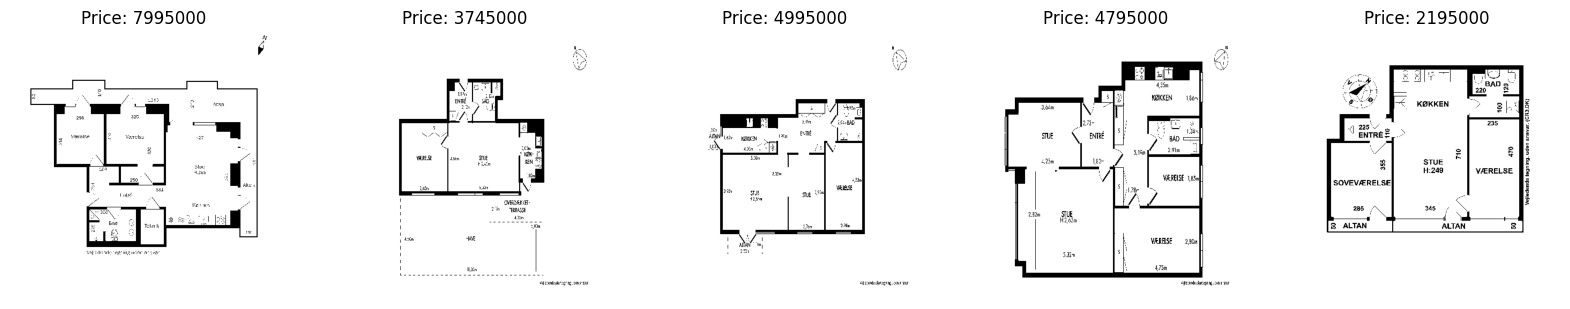

In [5]:
target_width = 500
target_height = 500

resize: bool = True
gray_scale: bool = False
threshhold: bool = True

train_images_RGB = preprocess_images(train_df, "image_floorplan", target_width, target_height, resize = resize, gray_scale = gray_scale, threshhold = threshhold)
validation_images_RGB = preprocess_images(valid_df, "image_floorplan", target_width, target_height, resize = resize, gray_scale = gray_scale, threshhold = threshhold)
test_images_RGB = preprocess_images(test_df, "image_floorplan", target_width, target_height, resize = resize, gray_scale = gray_scale, threshhold = threshhold)

train_prices = train_df['price']
validation_prices = valid_df['price']
test_prices = test_df['price']

#Plot the first 5 images and their prices 
fig, ax = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    ax[i].imshow(train_images_RGB[i])
    ax[i].set_title(f"Price: {train_prices.iloc[i]}")
    ax[i].axis('off')
plt.show()


# Model Fitting

2024-02-19 14:37:27.070268: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-19 14:37:27.091991: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-19 14:37:27.092084: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-19 14:37:27.093882: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-19 14:37:27.093983: I external/local_xla/xla/stream_executor

1 Physical GPUs, 1 Logical GPU


2024-02-19 14:37:27.473668: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-19 14:37:27.473841: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-19 14:37:27.473880: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2022] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2024-02-19 14:37:27.473946: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-19 14:37:27.473967: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 15, 15, 512)       14714688  
                                                                 
 flatten (Flatten)           (None, 115200)            0         
                                                                 
 dense (Dense)               (None, 1072)              123495472 
                                                                 
 dropout (Dropout)           (None, 1072)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               549376    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 5

2024-02-19 14:37:29.828185: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-19 14:37:30.120679: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-19 14:37:30.350300: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 839.97MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-19 14:37:30.350373: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 839.97MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-19 14:37:31.325696: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) r

7/8 [=========================>....] - ETA: 0s - loss: 4338760.5000

2024-02-19 14:38:02.344958: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.77GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-19 14:38:02.345036: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.77GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-19 14:38:02.786170: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.77GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


8/8 [==============================] - 59s 4s/step - loss: 4348919.5000 - val_loss: 4102738.7500
Epoch 2/100
8/8 [==============================] - 5s 621ms/step - loss: 4246710.5000 - val_loss: 3903545.5000
Epoch 3/100
8/8 [==============================] - 5s 620ms/step - loss: 3950676.5000 - val_loss: 3432438.0000
Epoch 4/100
8/8 [==============================] - 5s 616ms/step - loss: 3315523.0000 - val_loss: 2502034.7500
Epoch 5/100
8/8 [==============================] - 5s 613ms/step - loss: 2274368.5000 - val_loss: 1379507.6250
Epoch 6/100
8/8 [==============================] - 5s 623ms/step - loss: 1742444.8750 - val_loss: 1378721.1250
Epoch 7/100
8/8 [==============================] - 5s 632ms/step - loss: 1673503.2500 - val_loss: 1275048.2500
Epoch 8/100
8/8 [==============================] - 5s 641ms/step - loss: 1557642.0000 - val_loss: 1225574.6250
Epoch 9/100
8/8 [==============================] - 5s 635ms/step - loss: 1499966.6250 - val_loss: 1206738.8750
Epoch 10/100
8/

INFO:tensorflow:Assets written to: ./VGG16_regression_model/assets


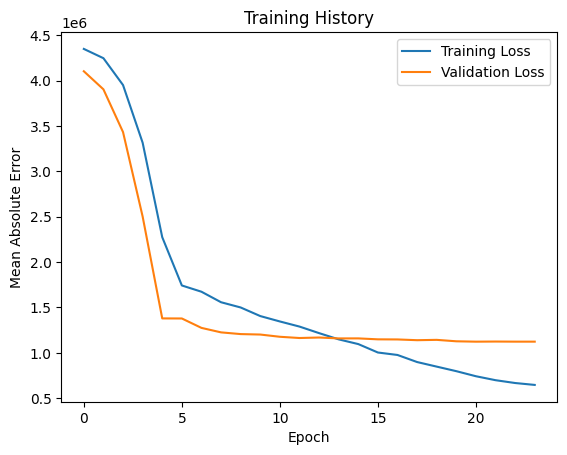

In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from multiprocessing import Process, Queue

def train_model(fine_tune_layers: int = 0):
    """
    Train a model with the VGG16 architecture and save the model to disk.
    
    Args:
        fine_tune_layers (int): Number of layers to fine-tune, counting from the top of the model.
    """
    set_gpu()
    
    # Load pre-trained VGG16 model (excluding top layers)
    input_shape = train_images_RGB[0].shape 
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the pre-trained layers
    for layer in base_model.layers[:-fine_tune_layers] if fine_tune_layers > 0 else base_model.layers:
        layer.trainable = False

    # Add new top layers for regression
    model = Sequential([
        base_model,
        Flatten(),
        Dense(1072, activation='relu'),
        Dropout(0.2),
        Dense(512, activation='relu'),
        Dropout(0.2),
        Dense(1, activation="linear")
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error')
    model.summary()

    # Train the model with early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(train_images_RGB, train_df["price"], validation_data=(validation_images_RGB, valid_df["price"]), epochs=100, callbacks=[early_stopping])

    model.save("./VGG16_regression_model")

    # Plot the training history
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.show()

p = Process(target=train_model, args=(0,))
p.start()
p.join()

# Model Evaluation

In [9]:
def evaluate_model(queue: Queue):
    set_gpu()
    
    # Evaluate the model
    loaded_model = tf.keras.models.load_model("./VGG16_regression_model")
    loaded_model.evaluate(test_images_RGB, test_df["price"])
    predictions = loaded_model.predict(test_images_RGB)
    
    queue.put(predictions)

2024-02-19 14:40:50.243590: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-19 14:40:50.271898: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-19 14:40:50.272004: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-19 14:40:50.275172: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-19 14:40:50.275347: I external/local_xla/xla/stream_executor

1 Physical GPUs, 1 Logical GPU


2024-02-19 14:40:50.479013: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-19 14:40:50.479251: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-19 14:40:50.479274: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2022] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2024-02-19 14:40:50.479338: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-19 14:40:50.479359: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created

1/3 [=========>....................] - ETA: 1:01 - loss: 2606507.0000

2024-02-19 14:41:26.744053: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


3/3 [==============================] - 1s 512ms/step
R2 score: 0.19
Mean Absolute Error: 2064933.35
Mean Squared Error: 9328648428910.72


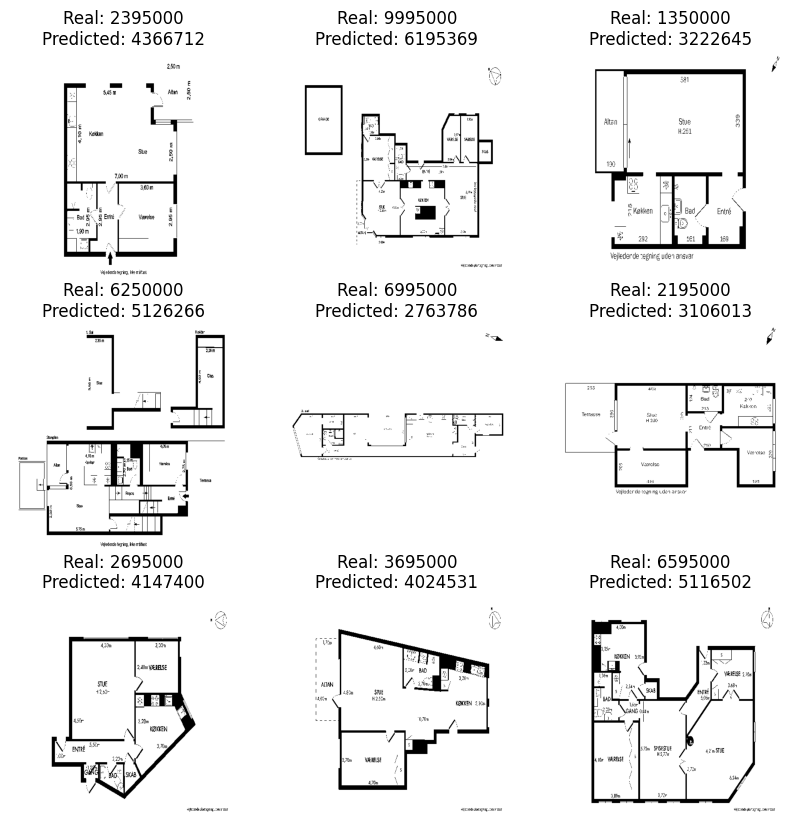

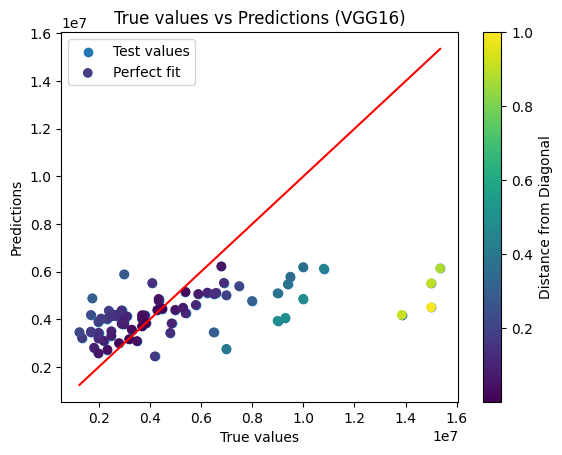

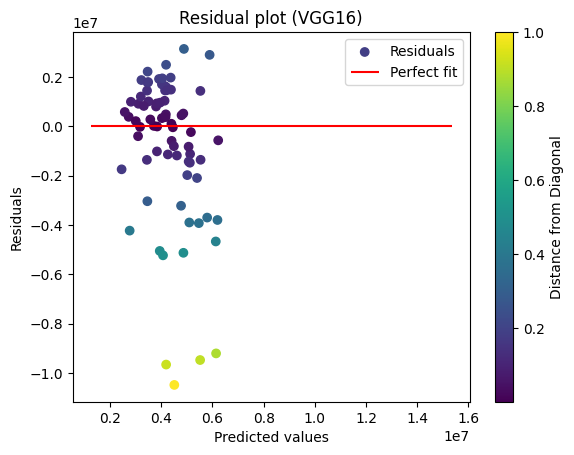

In [10]:
queue = Queue()
p = Process(target=evaluate_model, args=(queue,))
p.start()
p.join()

if queue.empty():
    raise ValueError("Nothing was returned from the process")
predictions = queue.get()
real_prices = test_df['price'].values
predicted_prices = predictions.flatten()

# Print the R2 score, MAE and MSE
print(f"R2 score: {r2_score(real_prices, predicted_prices):.2f}")
print(f"Mean Absolute Error: {mae(real_prices, predicted_prices):.2f}")
print(f"Mean Squared Error: {mse(real_prices, predicted_prices):.2f}")

# Plot the predictions
plt.figure(figsize=(10, 10))
for i, (image, label, prediction) in enumerate(zip(test_images_RGB[0:9], test_df["price"][0:9], predictions[0:9])):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Real: {label}\nPredicted: {prediction[0]:.0f}")
    plt.axis("off")
plt.show()

# Plot the predictions vs real prices
plot_regression_results('VGG16', real_prices, predicted_prices)

# Visualizing Predictions

## Saliency

1 Physical GPUs,

2024-02-19 14:41:38.952633: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-19 14:41:38.973525: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-19 14:41:38.973613: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-19 14:41:38.975542: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-19 14:41:38.975716: I external/local_xla/xla/stream_executor

 1 Logical GPU


2024-02-19 14:41:44.490618: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-19 14:41:44.657936: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-19 14:41:45.096742: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-19 14:41:45.286579: W external/local_tsl/tsl/framework/bfc_allocator.cc:366] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


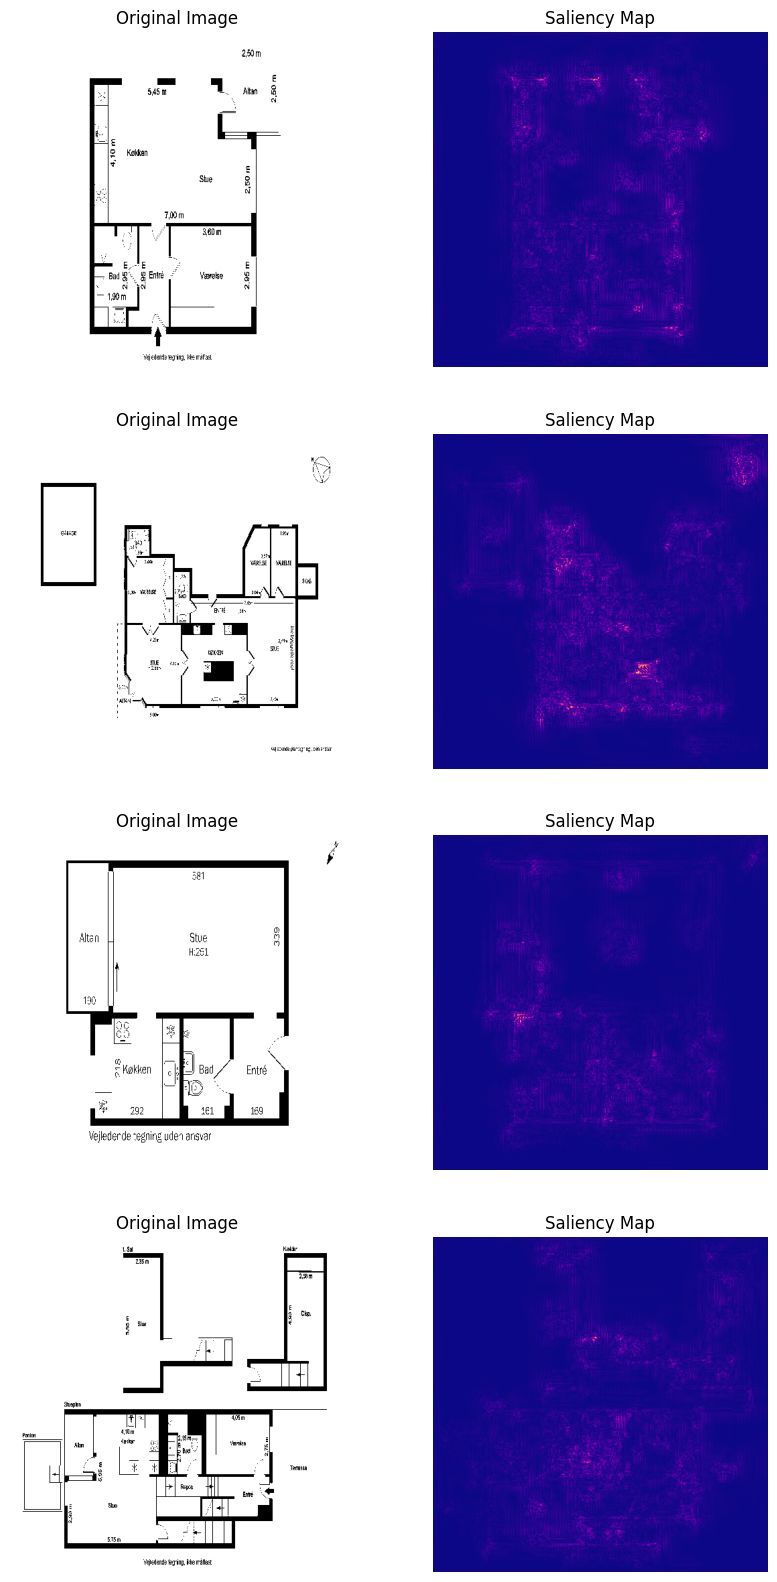

In [11]:
import numpy as np

def get_saliency_maps(images: np.ndarray):
    set_gpu()
    model = tf.keras.models.load_model("./VGG16_regression_model")
    saliency_maps = []
    for image in images:
        with tf.GradientTape() as tape:
            image = tf.convert_to_tensor(image, dtype=tf.float32)
            image = tf.expand_dims(image, axis=0)
            tape.watch(image)
            predictions = model(image)

        # Compute gradients of the output with respect to the input image
        gradient = tape.gradient(predictions, image)
        
        # Take absolute value of gradients to get saliency map
        saliency_map = tf.abs(gradient)
        
        # Reshape saliency map
        saliency_map = tf.reshape(saliency_map, image.shape[1:])  # Remove batch dimension
        
        # Normalize between 0 and 1
        saliency_map /= tf.reduce_max(saliency_map)

        # Set color channels to 0
        saliency_map = saliency_map[:, :, 0]

        saliency_maps.append(saliency_map)

    return saliency_maps

def plot_saliency_maps(images):
    fig, axes = plt.subplots(n_images, 2, figsize=(10, 5 * n_images))
    saliency_maps = get_saliency_maps(images)

    if len(images) > 1:
        for i, image in enumerate(images):
            # Plot the original image
            axes[i, 0].imshow(image)
            axes[i, 0].set_title("Original Image")
            axes[i, 0].axis("off")
            
            # Plot the saliency map
            axes[i, 1].imshow(saliency_maps[i], cmap="plasma")
            axes[i, 1].set_title("Saliency Map")
            axes[i, 1].axis("off")
    else:
        # Plot the original image
        axes[0].imshow(images[0])
        axes[0].set_title("Original Image")
        axes[0].axis("off")
        
        # Plot the saliency map
        axes[1].imshow(saliency_maps[0], cmap="plasma")
        axes[1].set_title("Saliency Map")
        axes[1].axis("off")

    plt.show()

n_images = 4

p = Process(target=plot_saliency_maps, args=(test_images_RGB[:n_images],))
p.start()
p.join()

## Class Activation Maps (doesn't work, WIP)

In [34]:
# from tensorflow.keras import backend as K

# def get_class_activation_maps(images: np.ndarray):
#     set_gpu()
#     model = tf.keras.models.load_model("./VGG16_regression_model")
#     classifier_layer = model.get_layer("dense_2")
#     base_model = model.get_layer("vgg16")
#     last_conv_layer = base_model.get_layer("block5_conv3")

#     class_activation_maps = []
#     for image in images:
#         # Convert the image to a tensor of type float32
#         image = tf.convert_to_tensor(image, dtype=tf.float32)
#         image = tf.expand_dims(image, axis=0)

#         # Get the model's prediction
#         predictions = model(image)

#         # Get the class with the highest probability
#         predicted_class = tf.argmax(predictions[0]).numpy()

#         # Get the output of the classifier layer for the predicted class
#         class_out = model.output[:, predicted_class]

#         # Get the output of the last convolutional layer
#         last_conv_output = last_conv_layer.output

#         with tf.GradientTape() as tape:
#             # Compute the gradient of the class output value with respect to the feature map
#             grads = tape.gradient(class_out, last_conv_output)

#         # Vector of shape (512,), where each entry is the mean intensity of the gradient over a specific feature map channel
#         pooled_grads = K.mean(grads, axis=(0, 1, 2))

#         # Multiply each channel in the feature map array by "how important this channel is" with regard to the class
#         last_conv_output_value = last_conv_output[0].numpy()
#         pooled_grads_value = pooled_grads.numpy()
#         for i in range(512):
#             last_conv_output_value[:, :, i] *= pooled_grads_value[i]

#         # The channel-wise mean of the resulting feature map is our class activation map
#         class_activation_map = np.mean(last_conv_output_value, axis=-1)

#         # Normalize between 0 and 1
#         class_activation_map -= np.min(class_activation_map)
#         class_activation_map /= np.max(class_activation_map)

#         class_activation_maps.append(class_activation_map)

#     return class_activation_maps

# def plot_class_activation_maps(images):
#     fig, axes = plt.subplots(n_images, 2, figsize=(10, 5 * n_images))
#     class_activation_maps = get_class_activation_maps(images)

#     if len(images) > 1:
#         for i, image in enumerate(images):
#             # Plot the original image
#             axes[i, 0].imshow(image)
#             axes[i, 0].set_title("Original Image")
#             axes[i, 0].axis("off")
            
#             # Plot the class activation map
#             axes[i, 1].imshow(class_activation_maps[i], cmap="plasma")
#             axes[i, 1].set_title("Class Activation Map")
#             axes[i, 1].axis("off")
#     else:
#         # Plot the original image
#         axes[0].imshow(images[0])
#         axes[0].set_title("Original Image")
#         axes[0].axis("off")
        
#         # Plot the class activation map
#         axes[1].imshow(class_activation_maps[0], cmap="plasma")
#         axes[1].set_title("Class Activation Map")
#         axes[1].axis("off")

#     plt.show()

# p = Process(target=plot_class_activation_maps, args=(test_images_RGB[:n_images],))
# p.start()
# p.join()

2024-02-19 16:06:54.623105: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-19 16:06:54.655787: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-19 16:06:54.655882: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-19 16:06:54.658036: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-19 16:06:54.658403: I external/local_xla/xla/stream_executor

1 Physical GPUs, 1 Logical GPU


2024-02-19 16:06:54.873844: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-19 16:06:54.873989: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-19 16:06:54.874008: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2022] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2024-02-19 16:06:54.874065: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-19 16:06:54.874083: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created